# Import Libraries

In [160]:
import pandas as pd
import numpy as np

import nltk

import itertools

from sentence_level_preprocess import *
from word_level_preprocess import *
from indexation import *
from featurize import *
from embeddings import Embeddings

from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator

In [178]:
numpy_records = List[Tuple]

def load_data(path: str) -> numpy_records:
    df = pd.read_csv(path, sep='\t')
    return df.to_records(index=False)

def preprocess(data: numpy_records) -> numpy_records:
    # remove line breaks (e.g. "elec- tron" -> "electron")
    data = [(rm_linebreaks(t), l) for t, l in data]

    # lower case
    data = [(t.lower(), l) for t, l in data]

    # unify expressions for temperature (e.g. '° c' -> '<temp>')
    data = [(c2temp_2(t), l) for t, l in data]

    data = [(nltk.tokenize.word_tokenize(t), l) for t, l in data]

    # recognize integer as '<int>' (e.g. '60' -> '<int>')
    data = [([put_int_together(w) for w in t], l) for t, l in data]

    # recognize decimal as '<dec>' (e.g. '0.5' -> '<dec>')
    data = [([put_decimal_together(w) for w in t], l) for t, l in data]

    # recognize ratioas '<ratio>' (e.g. '1:1' -> '<ratio>')
    data = [([put_ratio_together(w) for w in t], l) for t, l in data]

    # split slash (e.g. 'g/mol' -> '['g', '/', 'mol'])
    data = [([split_slash(w) for w in t], l) for t, l in data]
    data = [(list(itertools.chain.from_iterable(t)), l) for t, l in data] # flatten

    # unify expressions for temperature (e.g. '°c' -> '<temp>')
    data = [([c2temp(w) for w in t], l) for t, l in data]
    
    return data

def index_words(data: numpy_records):
    texts   = [x[0] for x in data]
    targets = [[x[1]] for x in data]
    texts, vocab_size, _   = word2idx(texts)
    targets, _, _          = word2idx(targets)
    targets = [l[0] for l in targets]
    data_idx = list(zip(texts, targets))
    return (data_idx, vocab_size, targets)

def BOW_featurize(data_idx, vocab_size):
    return [(bow(t, vocab_size), l) for t, l in data_idx]

def train_val_split(data: numpy_records) -> Tuple[List[str]]:
    X = [t for t, _ in data]
    y = [l for _, l in data]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    return (X_train, X_val, y_train, y_val)

def embed(embedding, train_data, val_data):
    return embedding.transform(
        train_data.text.apply(lambda x: ' '.join([str(y) for y in x]))
    ), embedding.transform(
        val_data.text.apply(lambda x: ' '.join([str(y) for y in x]))
    )

# def generate_embeddings(path: str, embed):
#     data_idx, vocab_size, targets = index_words(preprocess(load_data(path)))
#     X_total = pd.DataFrame(data_idx, columns=['text', 'classification'])
#     y_total = X_total.pop('classification')
#     X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2)
#     embeddings = Embeddings(X_train, X_val)
#     X_train, X_val = embed(embed, X_train, X_val)
#     return (X_train, X_val, y_train, y_val)

def generate_split(path):
    data_idx, vocab_size, targets = index_words(preprocess(load_data(path)))
    X_total = pd.DataFrame(data_idx, columns=['text', 'classification'])
    y_total = X_total.pop('classification')
    X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2)
    return (X_train, X_val, y_train, y_val)

def find_avg_performance(test_model: BaseEstimator, embedding_type, num_trial = 20) -> None:
    f1s = []

    for i in range(num_trial):
        X_train_avg, X_val_avg, y_train_avg, y_val_avg = generate_split('../data/train.tsv')
        X_train_avg, X_val_avg = embed(embedding_type, X_train_avg, X_val_avg)
        test_model.fit(X_train_avg, y_train_avg)
        y_pred = test_model.predict(X_val_avg)
        f1 = f1_score(y_val_avg, y_pred, average='micro')
        f1s.append(f1)

    print("mean:", np.mean(f1s))
    print("std :", np.std(f1s))

In [185]:
X_train, X_val, y_train, y_val = generate_split('../data/train.tsv')
embeddings = Embeddings(X_train, X_val)

### BOW Data

In [163]:
# embed_type = embeddings.BOW()
# X_train, X_val = embed(embed_type, X_train, X_val)

### TF-IDF Data

In [164]:
# embed_type = embeddings.TFIDF()
# X_train, X_val = embed(embeddings.TFIDF(), X_train, X_val)

### word2vec Data

In [186]:
embed_type = embeddings.word2vec()
X_train, X_val = embed(embed_type, X_train, X_val)

# Learn Classifiers

## Logistic regression

In [187]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7845303867403315

### Confusion matrix

In [125]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [78]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

<AxesSubplot:>

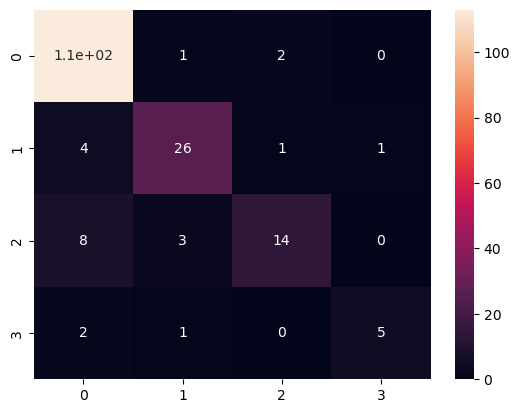

In [65]:
sns.heatmap(cm, annot=True)

<AxesSubplot:>

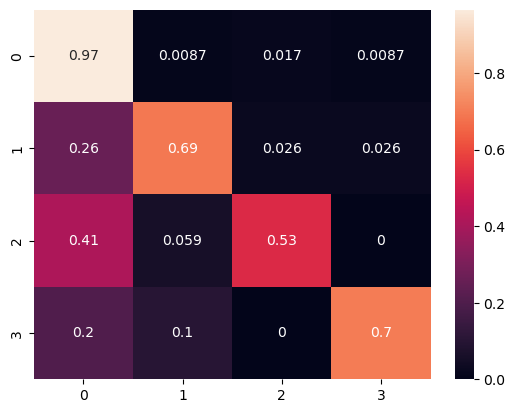

In [126]:
sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)

### Average performance

In [127]:
find_avg_performance(LogisticRegression(max_iter=5000), embed_type)

mean: 0.8359116022099448
std : 0.027463621042290786


### Hyperparameter Tuning

In [157]:
from sklearn.model_selection import GridSearchCV

In [188]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_lr, n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_grid.score(X_val, y_val)

/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

0.8397790055248618

In [103]:
find_avg_performance(lr_grid, embed_type)

KeyboardInterrupt: 

<AxesSubplot:>

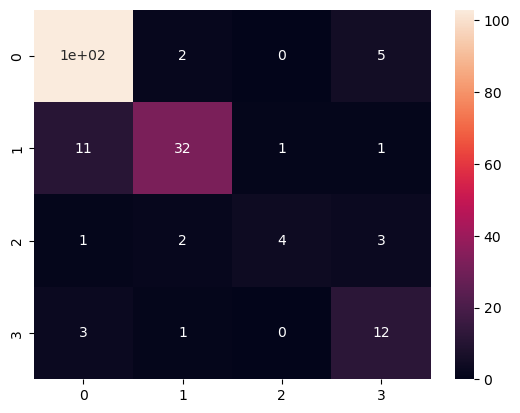

In [17]:
y_pred = lr_grid.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True)

## SVM

In [189]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_model.score(X_val, y_val)

0.6187845303867403

In [190]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale']
}

svm_grid = GridSearchCV(SVC(), param_grid_svm, refit=True, n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_grid.score(X_val, y_val)

0.8342541436464088

<AxesSubplot:>

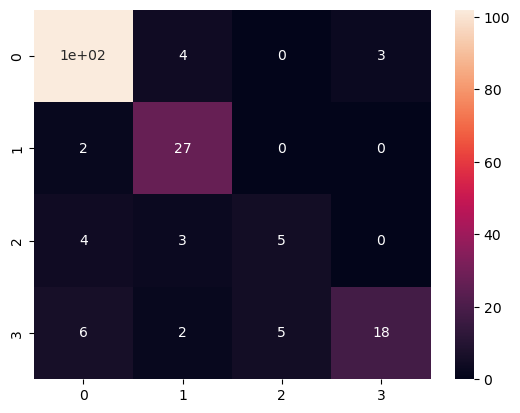

In [63]:
y_pred = svm_grid.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True)

## Attention

In [ ]:
from neural_network import RNN, NNTrainer
import torch

In [ ]:
train_set = pd.concat((X_train, y_train))
val_set = pd.concat((X_val, y_val))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

In [ ]:


nn_embed = RNN(4, 50, num_words, 100, False, word_types)
nn_w2v = RNN(4, 50, num_words, 100, False, word_types)
nn_w2v.set_embedding_weights()
nn_trainer_e = NNTrainer(
    nn_embed,
    5,
    torch.optim.Adam,
    torch.nn.CrossEntropyLoss(),
    train_loader,
    val_loader
)
nn_trainer_w = NNTrainer(
    nn_embed,
    5,
    torch.optim.Adam,
    torch.nn.CrossEntropyLoss(),
    train_loader,
    val_loader
)